In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb 

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv('../data/train.csv', sep='\t').rename(columns={'Unnamed: 0': 'index'})
test = pd.read_csv('../data/test.csv', sep='\t').rename(columns={'Unnamed: 0': 'index'})

In [3]:
# constant features on the test
conditions = {0:['129', '130', '137', '138', '140', '141', '149', 
                 '150', '164', '178', '186', '188', '192', '193',
                 '291', '301', '303', '305', '5'], 
              1:['11']}
# highly correlated features
redundant_cols = ['9', '160', '152', '191', '182', '185', '181', '172', '170', '157', '136', '135']
# reduntant features
redundant_cols += list(conditions.values())[0] + list(conditions.values())[1]

In [4]:
def new_features(data):
    '''This function concatenates some binary features in one feature'''
    res = ''
    for i in data:
        res += str(i)
    return res

In [5]:
def get_float_part(data, latest_col=False, non_int_cols=[]):
    '''This function selects columns whose datatypes are float64'''
    data_ = data.copy()
    dop_columns = [str(max(list(map(int, data_.drop(non_int_cols, axis=1).columns))) + i + 1) for i in range(2)]
    for column in dop_columns:
        data_[column] = 0.0
    float_cols = [i for i in data_.columns[1:] if np.dtype(data_[i]).name == 'float64']
    data_new = data_[float_cols]
    data_ = data_[float_cols + non_int_cols].drop(dop_columns, axis=1)
    return (data_new if latest_col else data_) 

In [6]:
def get_binary_grouped_intervals(data):
    '''This function returns continuous intervals of binary features'''
    data_ = data.copy()
    binary_intervals = []
    data_float = get_float_part(data_, latest_col=True)
    min_ = 0
    max_ = int(data_float.columns[0])
    for iter_ in data_float.columns[1:]:
        len_ = max_ - min_ - 1
        if len_ >= 2:
            binary_intervals.append((min_ + 1, min_ + len_ + 1))
        min_ = max_
        max_ = int(iter_)
    return binary_intervals

In [7]:
def get_binary_grouped_features(data, coding_columns, red_cols):
    '''This function creates dataframe with new features'''
    new_columns = pd.DataFrame()
    for columns in coding_columns:
        cols = [str(i) for i in range(*columns)]
        new_columns[str(columns[0]) + '_' + str(columns[1])] = data[cols].apply(
            lambda x: new_features(x), axis=1)
    for col in red_cols:
        new_columns[col] = data[col]
    return new_columns

In [8]:
def Label_training(columns):
    '''This function returns list of label encoders'''
    encoders = []
    for column in columns.columns:
        keys = {}
        for n_, value in zip(range(columns[column].nunique()), columns[column].unique()):
            keys.update({value: n_})
        encoders.append(keys)
    return encoders

In [9]:
def encoding_transform(columns, encoders, red_cols):
    '''This function transforms categorical features'''
    res = pd.DataFrame()
    for column, encoder in zip(columns.drop(red_cols, axis=1), encoders):
        to_transform = pd.DataFrame(columns[column])
        res[column] = to_transform[column].apply(lambda x: encoder.get(x))
    for col in red_cols:
        res[col] = columns[col]
    return res

In [10]:
def reindexing(list_, axis=1):
    '''This function re-indexes the dataframes columns'''
    size = len(list_)
    res = {}
    for i, column in zip(range(size), list_):
        res.update({column: (str(i) if axis==1 else i)})
    return res

In [11]:
def get_subframe(df, conditions):
    '''This function returns subframe thaе meets the conditions'''
    data_ = df.copy()
    for value, columns in conditions.items():
        for column in columns:
            data_ = data_[data_[column]==value]
    return data_

In [12]:
def get_intervals(intervals, n_):
    '''This function splits continious binary intervals'''
    inters = []
    for interval in intervals:
        size = interval[1] - interval[0]
        if size < n_:
            continue
        for i in range(size - n_ + 1):
            inters.append((interval[0] + i, interval[0] + i + n_))
    return inters

In [13]:
def generator(data, intervals, n_, red_cols):
    '''This function generates new features'''
    data_ = data.copy()
    intervals_ = get_intervals(intervals, n_)
    new_columns = get_binary_grouped_features(data_, intervals_, red_cols)
    encoders = Label_training(new_columns[new_columns[red_cols[0]]])
    return encoding_transform(new_columns ,encoders, red_cols)

In [14]:
train['is_train'] = True
test['is_train'] = False
all_df = pd.concat([train, test])
all_df = get_subframe(all_df, conditions)
all_df.drop(redundant_cols, axis=1, inplace=True)
all_df.rename(columns=reindexing(all_df.columns[1:-1]), inplace=True)
all_df.shape

(34543, 316)

In [15]:
intervals = get_binary_grouped_intervals(all_df.loc[all_df.is_train, all_df.columns[1:-1]])

In [16]:
intervals_agg = []
for i, j in enumerate(intervals):
    interval = all_df[list(all_df.columns[j[0] + 1: j[1] + 1]) + ['is_train', 'index']]
    cols = list(interval.columns[:-2])
    interval['inter' + str(i) + '_mean'] = interval[cols].mean(axis=1)
    interval['inter' + str(i) + '_median'] = interval[cols].median(axis=1)
    interval['inter' + str(i) + '_std'] = interval[cols].std(axis=1)
    interval.drop(cols, axis=1, inplace=True)
    intervals_agg.append(interval)

In [17]:
for i, j in enumerate(intervals_agg):
    int_train = j[j.is_train == True]
    int_train.to_csv('../features/interval' + str(i) + '_train.csv', index_label=False)
    int_test = j[~j.is_train == True]
    int_test.to_csv('../features/interval' + str(i) + '_test.csv', index_label=False)

In [18]:
floats = get_float_part(all_df, non_int_cols=['is_train', 'index'])
cols = list(floats.drop(['is_train', '0', 'index'], axis=1).columns)
floats['floats_max'] = floats[cols].max(axis=1)
floats['floats_mean'] = floats[cols].mean(axis=1)
floats['floats_median'] = floats[cols].median(axis=1)
floats['floats_std'] = floats[cols].std(axis=1)
floats_ = floats.drop(cols + ['0'], axis=1)
float_train = floats_[floats_.is_train]
float_train.to_csv('../features/float_train.csv', index_label=False)
float_test = floats_[~floats_.is_train]
float_test.to_csv('../features/float_test.csv', index_label=False)

len_i = []
for i in range(6):
    len_i.append(generator(all_df, intervals, 2 + i, red_cols=['is_train', 'index']))

for i, j in enumerate(len_i):
    group_train = j[j.is_train == True]
    group_train.to_csv('../features/step' + str(i + 2) + '_train.csv', index_label=False)
    group_test = j[~j.is_train == True]
    group_test.to_csv('../features/step' + str(i + 2) + '_test.csv', index_label=False)

In [19]:
def generator(data, intervals, n_, red_cols):
    '''This function generates new features'''
    data_ = data.copy()
    intervals_ = get_intervals(intervals, n_)
    new_columns = get_binary_grouped_features(data_, intervals_, red_cols)
    encoders = Label_training(new_columns[new_columns[red_cols[0]]])
    return encoding_transform(new_columns ,encoders, red_cols)

In [20]:
def get_binary_grouped_features(data, coding_columns, red_cols):
    '''This function creates dataframe with new features'''
    new_columns = pd.DataFrame()
    for columns in coding_columns:
        cols = [str(i) for i in range(*columns)]
        new_columns[str(columns[0]) + '_' + str(columns[1])] = data[cols].apply(
            lambda x: new_features(x), axis=1)
    for col in red_cols:
        new_columns[col] = data[col]
    return new_columns

In [21]:
def grouped_kits(data, kits, red_cols):
    new_columns = pd.DataFrame()
    for kit in kits:
        name = ''
        for column in kit:
            name += str(column) + '_'
        new_columns[name] = data[kit].apply(lambda x: new_features(x), axis=1) 
    for col in red_cols:
        new_columns[col] = data[col]
    return new_columns

In [22]:
def kits_generator(data, kits, red_cols):
    data_ = data.copy()
    new_columns =  grouped_kits(data_, kits, red_cols)
    encoders = Label_training(new_columns[new_columns[red_cols[0]]])
    return encoding_transform(new_columns ,encoders, red_cols)

In [23]:
all_df_new = all_df.copy()
categorical = []
len_cols = []
intervals_cols = []
'''
for i in len_i:
    all_df_new = all_df_new.merge(i, on=['index', 'is_train'], how='left')
    categorical += list(i.columns[:-2])
    len_cols.append(list(i.columns[:-2]))
'''

for i in intervals_agg:
    all_df_new = all_df_new.merge(i, on=['index', 'is_train'], how='left')
    intervals_cols.append(list(i.columns[2:]))
all_df_new = all_df_new.merge(floats_, on=['index', 'is_train'], how='left')
float_cols = list(floats_.columns[2:])

In [24]:
all_df_new = all_df.copy()
categorical = []
len_cols = []
intervals_cols = []
start_cols = list(all_df.columns[2:-1])
for i in range(len(intervals)):
    set2 = pd.read_csv('../features/interval' + str(i) + '_train.csv')
    set1 = pd.read_csv('../features/interval' + str(i) + '_test.csv')
    set0 = pd.concat([set2, set1])
    all_df_new = all_df_new.merge(set0, on=['index', 'is_train'], how='left')
    intervals_cols.append(list(set0.columns[2:]))
    
    '''
    if i > 1:
        set2 = pd.read_csv('../features/step' + str(i) + '_train.csv')
        set1 = pd.read_csv('../features/step' + str(i) + '_test.csv')
        set0 = pd.concat([set2, set1])
        all_df_new = all_df_new.merge(set0, on=['index', 'is_train'], how='left')
        categorical += list(set0.columns[:-2])
        len_cols.append(list(set0.columns[:-2]))   
    '''
    
set2 = pd.read_csv('../features/float_train.csv')
set1 = pd.read_csv('../features/float_test.csv')
set0 = pd.concat([set2, set1])
all_df_new = all_df_new.merge(set0, on=['index', 'is_train'], how='left')
float_cols = list(set0.columns[2:])
all_df_new.shape


(34543, 344)

In [25]:
train_new = all_df_new[all_df_new.is_train]
test_new = all_df_new[~ all_df_new.is_train]
start_cols = list(all_df.columns[2:-1])

In [26]:
def save_submission(prediction, filename):
    '''This function makes a submission files'''
    path = '../predictions/'
    submission = pd.Series (prediction, name='_VAL_' )
    submission.to_csv(path + filename, index_label='_ID_', header =True )

In [27]:
X_train = train_new.drop(['0', 'is_train', 'index'], axis=1)
y_train = train_new['0']
X_train.shape

(30377, 341)

In [28]:
all_df_new.head()

,index,0,1,2,3,4,5,6,7,8,...,inter6_mean,inter6_median,inter6_std,inter7_mean,inter7_median,inter7_std,floats_max,floats_mean,floats_median,floats_std
0,0,1.0,1,0,0,0,0,0.090909,0,1,...,0.25,0.0,0.5,1.00,1.0,0.0,1.0,0.324010,0.244962,0.313873
1,1,1.0,1,0,0,1,0,0.090909,0,1,...,0.25,0.0,0.5,0.75,1.0,0.5,1.0,0.319553,0.245754,0.296040
2,2,0.0,1,0,0,1,0,0.090909,0,1,...,0.25,0.0,0.5,1.00,1.0,0.0,1.0,0.286579,0.161165,0.311671
3,3,0.0,1,0,0,1,0,0.136364,0,1,...,0.25,0.0,0.5,0.75,1.0,0.5,1.0,0.324694,0.214331,0.309699
4,4,0.0,1,0,0,1,0,0.136364,0,1,...,0.25,0.0,0.5,1.00,1.0,0.0,1.0,0.314609,0.192571,0.316894


all_df_new.to_csv('all_df_with_all_features.csv', index_label=False)

In [29]:
train_cols = start_cols + ['floats_std', 'floats_median', 'floats_mean']
X = X_train[train_cols]
categorical_cols = [i for i in categorical if i in list(X.columns)]
y = y_train
X_test = test_new[train_cols]
X.shape, X_test.shape

((30377, 316), (4166, 316))


## XGBoost Features

import xgboost as xgb
import xgbfir

xgb_model = xgb.XGBClassifier(max_depth=10).fit(X_train, y_train)
xgbfir.saveXgbFI(xgb_model, 
                 MaxInteractionDepth=7,
                 feature_names=X_train.columns,
                 OutputXlsxFile='MODULBANK__.xlsx')

## LightGBM

In [30]:
skf = StratifiedKFold(n_splits=9, random_state=24)

In [31]:
lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)

In [33]:
parameters_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 24,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    'num_leaves': 75,
    'max_depth': 8,
    'min_data_in_leaf' : 15}

n_rounds = 10000

In [34]:
from sklearn.metrics import roc_auc_score
def check_train_score(params, lgb_data, data, target, kf, num_rounds):
    roc_auc = []
    for train, val in kf.split(data,target):
        temp_lgb_train = lgb_data.subset(train) 
        temp_lgb_val = lgb_data.subset(val)
        temp_model = lgb.train(params, temp_lgb_train, num_rounds, verbose_eval=num_rounds)
        roc_auc.append([roc_auc_score(target[train],temp_model.predict(data.loc[train])), roc_auc_score(target[val],temp_model.predict(data.loc[val]))])
    return np.mean(roc_auc, axis=0)

In [35]:
results_lgb = lgb.cv(parameters_lgb,
                lgb_train, 
                n_rounds, 
                folds=skf.split(X, y), 
                early_stopping_rounds=70, 
                verbose_eval=10)

[10]	cv_agg's auc: 0.720858 + 0.007346
[20]	cv_agg's auc: 0.722588 + 0.00670844
[30]	cv_agg's auc: 0.724208 + 0.00628061
[40]	cv_agg's auc: 0.725515 + 0.00607262
[50]	cv_agg's auc: 0.726481 + 0.00640231
[60]	cv_agg's auc: 0.726969 + 0.00651968
[70]	cv_agg's auc: 0.727517 + 0.00679529
[80]	cv_agg's auc: 0.728453 + 0.00667787
[90]	cv_agg's auc: 0.729304 + 0.00686555
[100]	cv_agg's auc: 0.730067 + 0.00677604
[110]	cv_agg's auc: 0.730754 + 0.00703935
[120]	cv_agg's auc: 0.731487 + 0.00698022
[130]	cv_agg's auc: 0.732221 + 0.00706947
[140]	cv_agg's auc: 0.732882 + 0.00715436
[150]	cv_agg's auc: 0.733484 + 0.00714293
[160]	cv_agg's auc: 0.734047 + 0.00724091
[170]	cv_agg's auc: 0.734986 + 0.0070912
[180]	cv_agg's auc: 0.73565 + 0.00715792
[190]	cv_agg's auc: 0.73626 + 0.00717785
[200]	cv_agg's auc: 0.737 + 0.00708678
[210]	cv_agg's auc: 0.737621 + 0.00713585
[220]	cv_agg's auc: 0.738262 + 0.00700864
[230]	cv_agg's auc: 0.738954 + 0.00707865
[240]	cv_agg's auc: 0.73939 + 0.00728602
[250]	cv_a

In [36]:
res = check_train_score(parameters_lgb, lgb_train, X, y, skf, len(results_lgb['auc-mean']))
on_train = res[0]
on_cv = res[1]
diff = on_train - on_cv
print(on_train, on_cv, diff)

0.9358348689217912 0.7475473213880021 0.18828754753378918


In [37]:
model_lgb = lgb.train(parameters_lgb, lgb_train, len(results_lgb['auc-mean']))

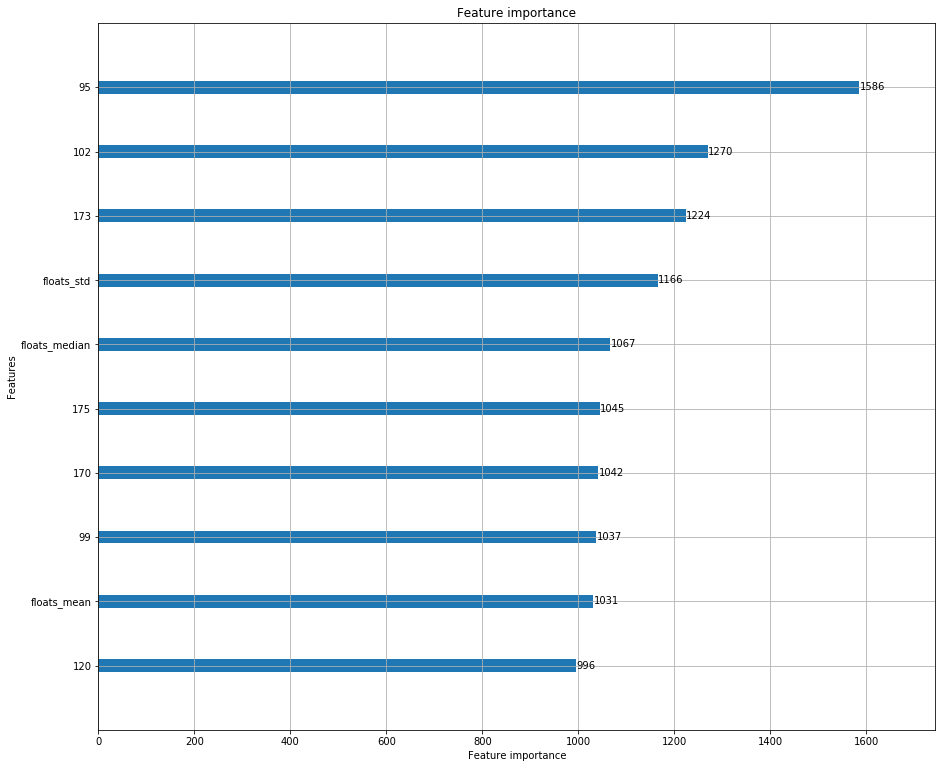

In [38]:
plt.rcParams['figure.figsize'] = (15, 13)
lgb.plot_importance(model_lgb, max_num_features=10)

In [95]:
test_lgb = model_lgb.predict(X_test)
save_submission(1 - test_lgb, 'submission_lightgbm_non_overfit.csv')

## XGBoost

In [40]:
X_train = X
y_train = y

In [41]:
from xgboost import XGBClassifier
import xgboost as xgb
xgb_train = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
xgb_test = xgb.DMatrix(X_test, feature_names=X_train.columns)

In [42]:
parameters_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 24,
    "eval_metric": 'auc',
   
    
    'max_depth':  8 ,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

In [43]:
results_xgb = xgb.cv(parameters_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=70, verbose_eval=10)

[0]	train-auc:0.714739+0.00369313	test-auc:0.679936+0.0023287
[10]	train-auc:0.764705+0.00758364	test-auc:0.712398+0.00497257
[20]	train-auc:0.770336+0.00683828	test-auc:0.714497+0.00527982
[30]	train-auc:0.775583+0.00491156	test-auc:0.715688+0.0049971
[40]	train-auc:0.778685+0.00502065	test-auc:0.716693+0.00505387
[50]	train-auc:0.783034+0.00554548	test-auc:0.718219+0.00498948
[60]	train-auc:0.786997+0.00551643	test-auc:0.719687+0.00432554
[70]	train-auc:0.790617+0.00523402	test-auc:0.720844+0.00439276
[80]	train-auc:0.794111+0.00473635	test-auc:0.721797+0.00446605
[90]	train-auc:0.797469+0.00460315	test-auc:0.722669+0.00415368
[100]	train-auc:0.801687+0.00437288	test-auc:0.72408+0.00401826
[110]	train-auc:0.805395+0.00472348	test-auc:0.725232+0.00409958
[120]	train-auc:0.8089+0.00433067	test-auc:0.726027+0.00408187
[130]	train-auc:0.812898+0.00343906	test-auc:0.726718+0.00400797
[140]	train-auc:0.816585+0.00355345	test-auc:0.727506+0.00394323
[150]	train-auc:0.820049+0.00316669	test-

In [44]:
model_xgb = xgb.train(parameters_xgb, xgb_train, len(results_xgb))

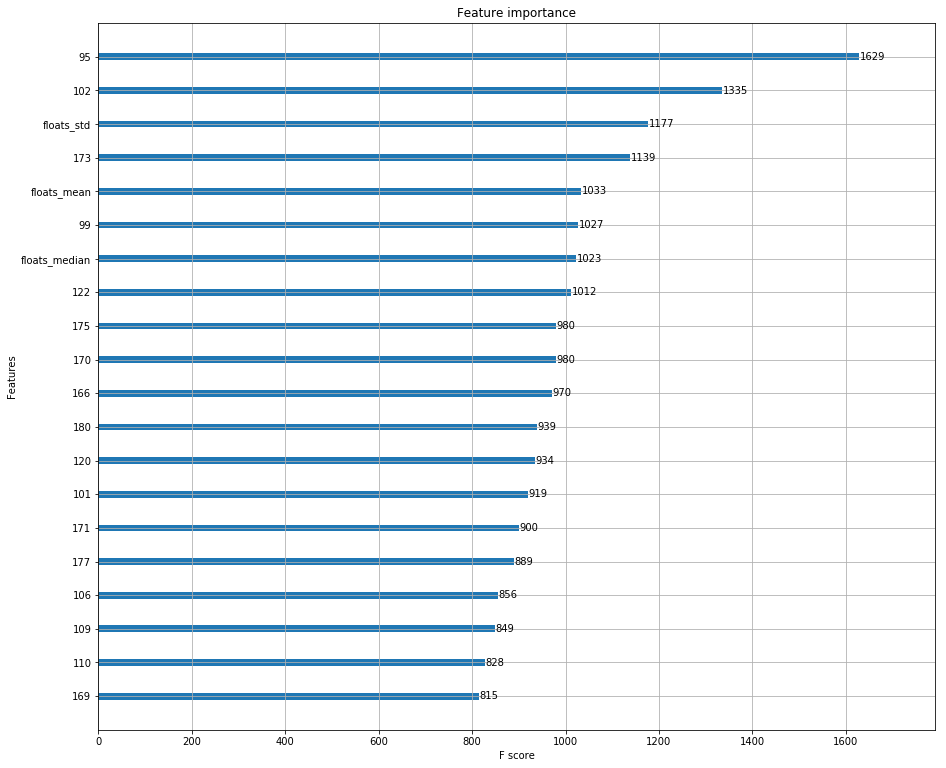

In [45]:
xgb.plot_importance(model_xgb, max_num_features=20)

In [96]:
test_xgb = model_xgb.predict(xgb_test)
save_submission(1 - test_xgb, 'submission_xgboost_non_overfit.csv')

## CatBoost

In [47]:
import catboost as ctb
ctb_train = ctb.Pool(X_train,y_train)

In [50]:
parameters_ctb = {
    #default
    'loss_function':'Logloss',
    'eval_metric': 'AUC',
    'iterations': 500,
    'learning_rate': 0.03,
    'random_seed': 24,
    'use_best_model': False,
    'od_wait': 50,
    'od_type': 'Iter',
    
    #regularization
    'rsm': 0.8,
    'l2_leaf_reg': 4,
    'depth': 8
    
}

ctb.cv(ctb_train, parameters_ctb, stratified=True, seed=24, logging_level='Verbose',nfold=9)

0:	learn: 0.6391263	test: 0.6339687	best: 0.6339687 (0)	total: 455ms	remaining: 3m 47s
1:	learn: 0.6634057	test: 0.6545987	best: 0.6545987 (1)	total: 1.01s	remaining: 4m 11s
2:	learn: 0.6698257	test: 0.6599840	best: 0.6599840 (2)	total: 1.48s	remaining: 4m 4s
3:	learn: 0.6738101	test: 0.6624082	best: 0.6624082 (3)	total: 1.97s	remaining: 4m 3s
4:	learn: 0.6863521	test: 0.6738391	best: 0.6738391 (4)	total: 2.46s	remaining: 4m 3s
5:	learn: 0.6867610	test: 0.6746069	best: 0.6746069 (5)	total: 2.95s	remaining: 4m 2s
6:	learn: 0.6887834	test: 0.6775321	best: 0.6775321 (6)	total: 3.43s	remaining: 4m 1s
7:	learn: 0.6901435	test: 0.6784598	best: 0.6784598 (7)	total: 3.92s	remaining: 4m 1s
8:	learn: 0.6942560	test: 0.6814796	best: 0.6814796 (8)	total: 4.42s	remaining: 4m 1s
9:	learn: 0.6945598	test: 0.6828491	best: 0.6828491 (9)	total: 4.87s	remaining: 3m 58s
10:	learn: 0.6947041	test: 0.6821973	best: 0.6828491 (9)	total: 5.38s	remaining: 3m 59s
11:	learn: 0.6937835	test: 0.6815450	best: 0.6828

93:	learn: 0.7463526	test: 0.7196938	best: 0.7196938 (93)	total: 50.1s	remaining: 3m 36s
94:	learn: 0.7467033	test: 0.7198710	best: 0.7198710 (94)	total: 50.7s	remaining: 3m 36s
95:	learn: 0.7471368	test: 0.7199800	best: 0.7199800 (95)	total: 51.3s	remaining: 3m 35s
96:	learn: 0.7475847	test: 0.7202659	best: 0.7202659 (96)	total: 51.8s	remaining: 3m 35s
97:	learn: 0.7482223	test: 0.7204979	best: 0.7204979 (97)	total: 52.3s	remaining: 3m 34s
98:	learn: 0.7485745	test: 0.7206482	best: 0.7206482 (98)	total: 52.8s	remaining: 3m 33s
99:	learn: 0.7489532	test: 0.7208092	best: 0.7208092 (99)	total: 53.3s	remaining: 3m 33s
100:	learn: 0.7492781	test: 0.7209425	best: 0.7209425 (100)	total: 53.8s	remaining: 3m 32s
101:	learn: 0.7496124	test: 0.7210778	best: 0.7210778 (101)	total: 54.3s	remaining: 3m 31s
102:	learn: 0.7500457	test: 0.7212971	best: 0.7212971 (102)	total: 54.8s	remaining: 3m 31s
103:	learn: 0.7503832	test: 0.7214389	best: 0.7214389 (103)	total: 55.4s	remaining: 3m 30s
104:	learn: 0

183:	learn: 0.7764050	test: 0.7308099	best: 0.7308099 (183)	total: 1m 35s	remaining: 2m 43s
184:	learn: 0.7766834	test: 0.7308780	best: 0.7308780 (184)	total: 1m 35s	remaining: 2m 43s
185:	learn: 0.7769410	test: 0.7308884	best: 0.7308884 (185)	total: 1m 36s	remaining: 2m 42s
186:	learn: 0.7772115	test: 0.7309611	best: 0.7309611 (186)	total: 1m 36s	remaining: 2m 42s
187:	learn: 0.7775011	test: 0.7310583	best: 0.7310583 (187)	total: 1m 37s	remaining: 2m 41s
188:	learn: 0.7777902	test: 0.7312880	best: 0.7312880 (188)	total: 1m 37s	remaining: 2m 41s
189:	learn: 0.7781172	test: 0.7314012	best: 0.7314012 (189)	total: 1m 38s	remaining: 2m 40s
190:	learn: 0.7784661	test: 0.7314633	best: 0.7314633 (190)	total: 1m 38s	remaining: 2m 40s
191:	learn: 0.7787697	test: 0.7315439	best: 0.7315439 (191)	total: 1m 39s	remaining: 2m 39s
192:	learn: 0.7789640	test: 0.7315250	best: 0.7315439 (191)	total: 1m 39s	remaining: 2m 38s
193:	learn: 0.7793437	test: 0.7317674	best: 0.7317674 (193)	total: 1m 40s	remain

273:	learn: 0.8011250	test: 0.7362846	best: 0.7362846 (273)	total: 2m 21s	remaining: 1m 56s
274:	learn: 0.8013227	test: 0.7363851	best: 0.7363851 (274)	total: 2m 22s	remaining: 1m 56s
275:	learn: 0.8015411	test: 0.7364174	best: 0.7364174 (275)	total: 2m 22s	remaining: 1m 55s
276:	learn: 0.8017624	test: 0.7364682	best: 0.7364682 (276)	total: 2m 23s	remaining: 1m 55s
277:	learn: 0.8019728	test: 0.7364760	best: 0.7364760 (277)	total: 2m 23s	remaining: 1m 54s
278:	learn: 0.8023088	test: 0.7365080	best: 0.7365080 (278)	total: 2m 24s	remaining: 1m 54s
279:	learn: 0.8026054	test: 0.7365874	best: 0.7365874 (279)	total: 2m 24s	remaining: 1m 53s
280:	learn: 0.8028557	test: 0.7366284	best: 0.7366284 (280)	total: 2m 25s	remaining: 1m 53s
281:	learn: 0.8030749	test: 0.7366143	best: 0.7366284 (280)	total: 2m 25s	remaining: 1m 52s
282:	learn: 0.8032125	test: 0.7366032	best: 0.7366284 (280)	total: 2m 26s	remaining: 1m 52s
283:	learn: 0.8034566	test: 0.7366113	best: 0.7366284 (280)	total: 2m 26s	remain

363:	learn: 0.8260018	test: 0.7390616	best: 0.7390616 (363)	total: 3m 9s	remaining: 1m 10s
364:	learn: 0.8262533	test: 0.7390257	best: 0.7390616 (363)	total: 3m 9s	remaining: 1m 10s
365:	learn: 0.8265370	test: 0.7390357	best: 0.7390616 (363)	total: 3m 10s	remaining: 1m 9s
366:	learn: 0.8267919	test: 0.7390951	best: 0.7390951 (366)	total: 3m 10s	remaining: 1m 9s
367:	learn: 0.8270305	test: 0.7390503	best: 0.7390951 (366)	total: 3m 11s	remaining: 1m 8s
368:	learn: 0.8273348	test: 0.7390899	best: 0.7390951 (366)	total: 3m 11s	remaining: 1m 8s
369:	learn: 0.8276470	test: 0.7390939	best: 0.7390951 (366)	total: 3m 12s	remaining: 1m 7s
370:	learn: 0.8278387	test: 0.7391391	best: 0.7391391 (370)	total: 3m 12s	remaining: 1m 6s
371:	learn: 0.8281209	test: 0.7391165	best: 0.7391391 (370)	total: 3m 13s	remaining: 1m 6s
372:	learn: 0.8283909	test: 0.7391676	best: 0.7391676 (372)	total: 3m 13s	remaining: 1m 5s
373:	learn: 0.8286485	test: 0.7392225	best: 0.7392225 (373)	total: 3m 14s	remaining: 1m 5s

454:	learn: 0.8509477	test: 0.7403659	best: 0.7404394 (446)	total: 3m 56s	remaining: 23.4s
455:	learn: 0.8511631	test: 0.7404582	best: 0.7404582 (455)	total: 3m 56s	remaining: 22.8s
456:	learn: 0.8514080	test: 0.7404755	best: 0.7404755 (456)	total: 3m 57s	remaining: 22.3s
457:	learn: 0.8517146	test: 0.7405199	best: 0.7405199 (457)	total: 3m 57s	remaining: 21.8s
458:	learn: 0.8520885	test: 0.7405124	best: 0.7405199 (457)	total: 3m 58s	remaining: 21.3s
459:	learn: 0.8523536	test: 0.7404912	best: 0.7405199 (457)	total: 3m 58s	remaining: 20.8s
460:	learn: 0.8526699	test: 0.7404969	best: 0.7405199 (457)	total: 3m 59s	remaining: 20.3s
461:	learn: 0.8529519	test: 0.7404815	best: 0.7405199 (457)	total: 3m 59s	remaining: 19.7s
462:	learn: 0.8531710	test: 0.7404801	best: 0.7405199 (457)	total: 4m	remaining: 19.2s
463:	learn: 0.8534456	test: 0.7405117	best: 0.7405199 (457)	total: 4m	remaining: 18.7s
464:	learn: 0.8537284	test: 0.7405169	best: 0.7405199 (457)	total: 4m 1s	remaining: 18.2s
465:	lea

,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-AUC-mean,train-AUC-std,train-Logloss-mean,train-Logloss-std
0,0.633969,0.015409,0.676663,0.000247,0.639126,0.012509,0.676607,0.000255
1,0.654599,0.012746,0.661383,0.000352,0.663406,0.008929,0.661210,0.000523
2,0.659984,0.012484,0.647218,0.000099,0.669826,0.006603,0.646979,0.000330
3,0.662408,0.012660,0.634238,0.000193,0.673810,0.006870,0.633916,0.000216
4,0.673839,0.006629,0.621368,0.000421,0.686352,0.009057,0.620968,0.000713
5,0.674607,0.005093,0.609612,0.000505,0.686761,0.007366,0.609128,0.000834
6,0.677532,0.003807,0.598703,0.000824,0.688783,0.004570,0.598119,0.001247
7,0.678460,0.005010,0.588343,0.000782,0.690144,0.004730,0.587669,0.001252
8,0.681480,0.002243,0.578909,0.001093,0.694256,0.005422,0.578131,0.001552
9,0.682849,0.000872,0.570357,0.001579,0.694560,0.005281,0.569589,0.002059


In [52]:
model_ctb = ctb.train(ctb_train, parameters_ctb, logging_level='Verbose',num_boost_round=484)

0:	learn: 0.6425309	total: 216ms	remaining: 1m 44s
1:	learn: 0.6693908	total: 452ms	remaining: 1m 48s
2:	learn: 0.6769180	total: 707ms	remaining: 1m 53s
3:	learn: 0.6776043	total: 924ms	remaining: 1m 50s
4:	learn: 0.6796370	total: 1.24s	remaining: 1m 58s
5:	learn: 0.6808412	total: 1.52s	remaining: 2m
6:	learn: 0.6871023	total: 1.78s	remaining: 2m 1s
7:	learn: 0.6875353	total: 2.09s	remaining: 2m 4s
8:	learn: 0.6892387	total: 2.43s	remaining: 2m 8s
9:	learn: 0.6909205	total: 2.73s	remaining: 2m 9s
10:	learn: 0.6934687	total: 3.03s	remaining: 2m 10s
11:	learn: 0.6951895	total: 3.41s	remaining: 2m 14s
12:	learn: 0.6963886	total: 3.63s	remaining: 2m 11s
13:	learn: 0.6983938	total: 3.89s	remaining: 2m 10s
14:	learn: 0.6989082	total: 4.25s	remaining: 2m 12s
15:	learn: 0.7006540	total: 4.5s	remaining: 2m 11s
16:	learn: 0.7006430	total: 4.74s	remaining: 2m 10s
17:	learn: 0.7026928	total: 5s	remaining: 2m 9s
18:	learn: 0.7032088	total: 5.23s	remaining: 2m 8s
19:	learn: 0.7039206	total: 5.48s	re

158:	learn: 0.7617861	total: 42.6s	remaining: 1m 27s
159:	learn: 0.7619737	total: 42.9s	remaining: 1m 26s
160:	learn: 0.7621707	total: 43.1s	remaining: 1m 26s
161:	learn: 0.7625611	total: 43.4s	remaining: 1m 26s
162:	learn: 0.7628662	total: 43.7s	remaining: 1m 26s
163:	learn: 0.7631460	total: 43.9s	remaining: 1m 25s
164:	learn: 0.7632618	total: 44.2s	remaining: 1m 25s
165:	learn: 0.7634013	total: 44.4s	remaining: 1m 25s
166:	learn: 0.7636007	total: 44.7s	remaining: 1m 24s
167:	learn: 0.7639592	total: 44.9s	remaining: 1m 24s
168:	learn: 0.7641562	total: 45.2s	remaining: 1m 24s
169:	learn: 0.7644977	total: 45.5s	remaining: 1m 23s
170:	learn: 0.7647330	total: 45.7s	remaining: 1m 23s
171:	learn: 0.7649733	total: 46s	remaining: 1m 23s
172:	learn: 0.7651683	total: 46.2s	remaining: 1m 23s
173:	learn: 0.7652353	total: 46.5s	remaining: 1m 22s
174:	learn: 0.7654671	total: 46.7s	remaining: 1m 22s
175:	learn: 0.7656672	total: 47s	remaining: 1m 22s
176:	learn: 0.7658977	total: 47.2s	remaining: 1m 2

315:	learn: 0.7934577	total: 1m 24s	remaining: 44.7s
316:	learn: 0.7936353	total: 1m 24s	remaining: 44.4s
317:	learn: 0.7937228	total: 1m 24s	remaining: 44.2s
318:	learn: 0.7940202	total: 1m 24s	remaining: 43.9s
319:	learn: 0.7942151	total: 1m 25s	remaining: 43.6s
320:	learn: 0.7944246	total: 1m 25s	remaining: 43.3s
321:	learn: 0.7945747	total: 1m 25s	remaining: 43.1s
322:	learn: 0.7948743	total: 1m 25s	remaining: 42.8s
323:	learn: 0.7950440	total: 1m 26s	remaining: 42.5s
324:	learn: 0.7952504	total: 1m 26s	remaining: 42.3s
325:	learn: 0.7955090	total: 1m 26s	remaining: 42s
326:	learn: 0.7956013	total: 1m 26s	remaining: 41.7s
327:	learn: 0.7957671	total: 1m 27s	remaining: 41.4s
328:	learn: 0.7960107	total: 1m 27s	remaining: 41.2s
329:	learn: 0.7962462	total: 1m 27s	remaining: 40.9s
330:	learn: 0.7965158	total: 1m 27s	remaining: 40.6s
331:	learn: 0.7968104	total: 1m 28s	remaining: 40.4s
332:	learn: 0.7972448	total: 1m 28s	remaining: 40.1s
333:	learn: 0.7974671	total: 1m 28s	remaining: 3

471:	learn: 0.8282240	total: 2m 4s	remaining: 3.16s
472:	learn: 0.8284468	total: 2m 4s	remaining: 2.9s
473:	learn: 0.8285276	total: 2m 4s	remaining: 2.64s
474:	learn: 0.8287387	total: 2m 5s	remaining: 2.37s
475:	learn: 0.8288959	total: 2m 5s	remaining: 2.11s
476:	learn: 0.8290444	total: 2m 5s	remaining: 1.84s
477:	learn: 0.8291379	total: 2m 5s	remaining: 1.58s
478:	learn: 0.8292928	total: 2m 6s	remaining: 1.32s
479:	learn: 0.8294523	total: 2m 6s	remaining: 1.05s
480:	learn: 0.8296126	total: 2m 6s	remaining: 791ms
481:	learn: 0.8297511	total: 2m 7s	remaining: 527ms
482:	learn: 0.8299524	total: 2m 7s	remaining: 263ms
483:	learn: 0.8301731	total: 2m 7s	remaining: 0us


In [97]:
test_ctb = model_ctb.predict(X_test, prediction_type='Probability')[:,1]
save_submission(1 - test_ctb, 'submission_ctboost_non_overfit.csv')

## Ensemble

In [62]:
pred_cv_xgb = []
pred_cv_lgb = []    
pred_cv_ctb = []
for train, val in skf.split(X_train, y_train):
    print('New_fold:', end=' ')
    print('__XGB__', end=' ')
    xgb_train_temp = xgb.DMatrix(X_train.iloc[train], y_train[train])
    temp_xgb_model = xgb.train(parameters_xgb, xgb_train_temp , len(results_xgb))
    pred_cv_xgb.append([y_train[val], temp_xgb_model.predict(xgb.DMatrix(X_train.iloc[val]))])
    print('__CTB__', end=' ')
    ctb_train_temp = ctb.Pool(X_train.iloc[train], y_train[train])
    temp_ctb_model = ctb.train(ctb_train_temp , parameters_ctb, num_boost_round=484)
    pred_cv_ctb.append([y_train[val], temp_ctb_model.predict(X_train.iloc[val], prediction_type='Probability')])
    print('__LGB__')
    lgb_train_temp = lgb.Dataset(X_train.iloc[train], y_train[train])
    temp_lgb_model = lgb.train(parameters_lgb,lgb_train_temp , len(results_lgb['auc-mean']))
    pred_cv_lgb.append([y_train[val], temp_lgb_model.predict(X_train.iloc[val])])

New_fold: __XGB__ __CTB__ 0:	learn: 0.6326712	total: 187ms	remaining: 1m 30s
1:	learn: 0.6556737	total: 464ms	remaining: 1m 51s
2:	learn: 0.6588953	total: 767ms	remaining: 2m 2s
3:	learn: 0.6682270	total: 1.1s	remaining: 2m 11s
4:	learn: 0.6806050	total: 1.38s	remaining: 2m 11s
5:	learn: 0.6829450	total: 1.71s	remaining: 2m 16s
6:	learn: 0.6843267	total: 1.98s	remaining: 2m 14s
7:	learn: 0.6864957	total: 2.3s	remaining: 2m 16s
8:	learn: 0.6881050	total: 2.61s	remaining: 2m 17s
9:	learn: 0.6929489	total: 2.86s	remaining: 2m 15s
10:	learn: 0.6929955	total: 3.14s	remaining: 2m 15s
11:	learn: 0.6951942	total: 3.4s	remaining: 2m 13s
12:	learn: 0.6942821	total: 3.65s	remaining: 2m 12s
13:	learn: 0.6966494	total: 3.88s	remaining: 2m 10s
14:	learn: 0.6978602	total: 4.13s	remaining: 2m 9s
15:	learn: 0.6985902	total: 4.4s	remaining: 2m 8s
16:	learn: 0.6996258	total: 4.65s	remaining: 2m 7s
17:	learn: 0.6996896	total: 4.87s	remaining: 2m 6s
18:	learn: 0.7011371	total: 5.11s	remaining: 2m 5s
19:	le

158:	learn: 0.7644694	total: 40.7s	remaining: 1m 23s
159:	learn: 0.7646998	total: 40.9s	remaining: 1m 22s
160:	learn: 0.7650082	total: 41.2s	remaining: 1m 22s
161:	learn: 0.7654153	total: 41.4s	remaining: 1m 22s
162:	learn: 0.7656710	total: 41.6s	remaining: 1m 21s
163:	learn: 0.7658582	total: 41.9s	remaining: 1m 21s
164:	learn: 0.7661573	total: 42.1s	remaining: 1m 21s
165:	learn: 0.7665353	total: 42.3s	remaining: 1m 21s
166:	learn: 0.7667390	total: 42.5s	remaining: 1m 20s
167:	learn: 0.7670002	total: 42.8s	remaining: 1m 20s
168:	learn: 0.7673010	total: 43s	remaining: 1m 20s
169:	learn: 0.7675585	total: 43.2s	remaining: 1m 19s
170:	learn: 0.7677530	total: 43.5s	remaining: 1m 19s
171:	learn: 0.7681082	total: 43.7s	remaining: 1m 19s
172:	learn: 0.7683034	total: 43.9s	remaining: 1m 19s
173:	learn: 0.7686905	total: 44.2s	remaining: 1m 18s
174:	learn: 0.7689606	total: 44.4s	remaining: 1m 18s
175:	learn: 0.7691843	total: 44.7s	remaining: 1m 18s
176:	learn: 0.7693771	total: 44.9s	remaining: 1m

315:	learn: 0.8002863	total: 1m 21s	remaining: 43.2s
316:	learn: 0.8005183	total: 1m 21s	remaining: 43s
317:	learn: 0.8006817	total: 1m 21s	remaining: 42.7s
318:	learn: 0.8008409	total: 1m 22s	remaining: 42.5s
319:	learn: 0.8008938	total: 1m 22s	remaining: 42.2s
320:	learn: 0.8010237	total: 1m 22s	remaining: 42s
321:	learn: 0.8012539	total: 1m 23s	remaining: 41.9s
322:	learn: 0.8014936	total: 1m 23s	remaining: 41.7s
323:	learn: 0.8017268	total: 1m 23s	remaining: 41.4s
324:	learn: 0.8019308	total: 1m 24s	remaining: 41.2s
325:	learn: 0.8021979	total: 1m 24s	remaining: 41s
326:	learn: 0.8026491	total: 1m 24s	remaining: 40.7s
327:	learn: 0.8028977	total: 1m 25s	remaining: 40.5s
328:	learn: 0.8032146	total: 1m 25s	remaining: 40.3s
329:	learn: 0.8033377	total: 1m 26s	remaining: 40.1s
330:	learn: 0.8035633	total: 1m 26s	remaining: 39.9s
331:	learn: 0.8037226	total: 1m 26s	remaining: 39.7s
332:	learn: 0.8038632	total: 1m 27s	remaining: 39.5s
333:	learn: 0.8040477	total: 1m 27s	remaining: 39.2s

472:	learn: 0.8358530	total: 2m 10s	remaining: 3.03s
473:	learn: 0.8360253	total: 2m 10s	remaining: 2.75s
474:	learn: 0.8361955	total: 2m 10s	remaining: 2.48s
475:	learn: 0.8364074	total: 2m 11s	remaining: 2.2s
476:	learn: 0.8366545	total: 2m 11s	remaining: 1.93s
477:	learn: 0.8368231	total: 2m 11s	remaining: 1.65s
478:	learn: 0.8368670	total: 2m 12s	remaining: 1.38s
479:	learn: 0.8370404	total: 2m 12s	remaining: 1.1s
480:	learn: 0.8372819	total: 2m 12s	remaining: 828ms
481:	learn: 0.8374006	total: 2m 13s	remaining: 552ms
482:	learn: 0.8375633	total: 2m 13s	remaining: 276ms
483:	learn: 0.8378233	total: 2m 13s	remaining: 0us
__LGB__
New_fold: __XGB__ __CTB__ 0:	learn: 0.6351111	total: 156ms	remaining: 1m 15s
1:	learn: 0.6597089	total: 376ms	remaining: 1m 30s
2:	learn: 0.6702408	total: 603ms	remaining: 1m 36s
3:	learn: 0.6750159	total: 836ms	remaining: 1m 40s
4:	learn: 0.6858220	total: 1.04s	remaining: 1m 39s
5:	learn: 0.6896585	total: 1.26s	remaining: 1m 40s
6:	learn: 0.6917763	total: 1

145:	learn: 0.7626279	total: 32.6s	remaining: 1m 15s
146:	learn: 0.7628575	total: 32.8s	remaining: 1m 15s
147:	learn: 0.7630183	total: 33s	remaining: 1m 14s
148:	learn: 0.7633865	total: 33.3s	remaining: 1m 14s
149:	learn: 0.7638441	total: 33.5s	remaining: 1m 14s
150:	learn: 0.7641732	total: 33.7s	remaining: 1m 14s
151:	learn: 0.7645985	total: 33.9s	remaining: 1m 14s
152:	learn: 0.7649027	total: 34.1s	remaining: 1m 13s
153:	learn: 0.7652687	total: 34.3s	remaining: 1m 13s
154:	learn: 0.7655654	total: 34.5s	remaining: 1m 13s
155:	learn: 0.7656922	total: 34.8s	remaining: 1m 13s
156:	learn: 0.7660388	total: 35s	remaining: 1m 12s
157:	learn: 0.7663640	total: 35.2s	remaining: 1m 12s
158:	learn: 0.7666317	total: 35.4s	remaining: 1m 12s
159:	learn: 0.7669986	total: 35.7s	remaining: 1m 12s
160:	learn: 0.7673491	total: 35.9s	remaining: 1m 12s
161:	learn: 0.7675937	total: 36.1s	remaining: 1m 11s
162:	learn: 0.7679049	total: 36.3s	remaining: 1m 11s
163:	learn: 0.7682371	total: 36.6s	remaining: 1m 1

304:	learn: 0.8000816	total: 1m 14s	remaining: 43.8s
305:	learn: 0.8001071	total: 1m 14s	remaining: 43.6s
306:	learn: 0.8004377	total: 1m 15s	remaining: 43.3s
307:	learn: 0.8006155	total: 1m 15s	remaining: 43.1s
308:	learn: 0.8007439	total: 1m 15s	remaining: 42.9s
309:	learn: 0.8008852	total: 1m 16s	remaining: 42.7s
310:	learn: 0.8010518	total: 1m 16s	remaining: 42.5s
311:	learn: 0.8011449	total: 1m 16s	remaining: 42.2s
312:	learn: 0.8012885	total: 1m 16s	remaining: 42s
313:	learn: 0.8014094	total: 1m 17s	remaining: 41.8s
314:	learn: 0.8016897	total: 1m 17s	remaining: 41.6s
315:	learn: 0.8019332	total: 1m 17s	remaining: 41.4s
316:	learn: 0.8022260	total: 1m 18s	remaining: 41.1s
317:	learn: 0.8024887	total: 1m 18s	remaining: 40.9s
318:	learn: 0.8028124	total: 1m 18s	remaining: 40.7s
319:	learn: 0.8029947	total: 1m 18s	remaining: 40.5s
320:	learn: 0.8032887	total: 1m 19s	remaining: 40.2s
321:	learn: 0.8035629	total: 1m 19s	remaining: 40s
322:	learn: 0.8037299	total: 1m 19s	remaining: 39.

460:	learn: 0.8353557	total: 2m	remaining: 6s
461:	learn: 0.8355787	total: 2m	remaining: 5.74s
462:	learn: 0.8357742	total: 2m	remaining: 5.48s
463:	learn: 0.8361077	total: 2m 1s	remaining: 5.22s
464:	learn: 0.8362851	total: 2m 1s	remaining: 4.97s
465:	learn: 0.8365482	total: 2m 1s	remaining: 4.71s
466:	learn: 0.8367782	total: 2m 2s	remaining: 4.45s
467:	learn: 0.8369650	total: 2m 2s	remaining: 4.19s
468:	learn: 0.8371439	total: 2m 2s	remaining: 3.93s
469:	learn: 0.8373202	total: 2m 3s	remaining: 3.67s
470:	learn: 0.8375913	total: 2m 3s	remaining: 3.41s
471:	learn: 0.8377324	total: 2m 3s	remaining: 3.15s
472:	learn: 0.8378623	total: 2m 4s	remaining: 2.89s
473:	learn: 0.8379592	total: 2m 4s	remaining: 2.63s
474:	learn: 0.8381271	total: 2m 4s	remaining: 2.37s
475:	learn: 0.8383774	total: 2m 5s	remaining: 2.1s
476:	learn: 0.8384467	total: 2m 5s	remaining: 1.84s
477:	learn: 0.8386406	total: 2m 5s	remaining: 1.58s
478:	learn: 0.8388120	total: 2m 6s	remaining: 1.32s
479:	learn: 0.8390913	tot

134:	learn: 0.7551621	total: 32.5s	remaining: 1m 23s
135:	learn: 0.7555337	total: 32.7s	remaining: 1m 23s
136:	learn: 0.7559513	total: 33s	remaining: 1m 23s
137:	learn: 0.7562796	total: 33.2s	remaining: 1m 23s
138:	learn: 0.7565036	total: 33.5s	remaining: 1m 23s
139:	learn: 0.7569371	total: 33.7s	remaining: 1m 22s
140:	learn: 0.7573200	total: 33.9s	remaining: 1m 22s
141:	learn: 0.7577905	total: 34.2s	remaining: 1m 22s
142:	learn: 0.7580720	total: 34.4s	remaining: 1m 22s
143:	learn: 0.7581717	total: 34.7s	remaining: 1m 21s
144:	learn: 0.7583161	total: 34.9s	remaining: 1m 21s
145:	learn: 0.7586819	total: 35.1s	remaining: 1m 21s
146:	learn: 0.7589788	total: 35.4s	remaining: 1m 21s
147:	learn: 0.7592075	total: 35.6s	remaining: 1m 20s
148:	learn: 0.7594098	total: 35.8s	remaining: 1m 20s
149:	learn: 0.7596119	total: 36.1s	remaining: 1m 20s
150:	learn: 0.7600583	total: 36.4s	remaining: 1m 20s
151:	learn: 0.7603827	total: 36.6s	remaining: 1m 19s
152:	learn: 0.7606532	total: 36.9s	remaining: 1m

292:	learn: 0.7930998	total: 1m 12s	remaining: 47.5s
293:	learn: 0.7932063	total: 1m 13s	remaining: 47.3s
294:	learn: 0.7935522	total: 1m 13s	remaining: 47s
295:	learn: 0.7937395	total: 1m 13s	remaining: 46.8s
296:	learn: 0.7938781	total: 1m 13s	remaining: 46.5s
297:	learn: 0.7940220	total: 1m 14s	remaining: 46.3s
298:	learn: 0.7943732	total: 1m 14s	remaining: 46s
299:	learn: 0.7946575	total: 1m 14s	remaining: 45.8s
300:	learn: 0.7948759	total: 1m 14s	remaining: 45.5s
301:	learn: 0.7951646	total: 1m 15s	remaining: 45.2s
302:	learn: 0.7953770	total: 1m 15s	remaining: 45s
303:	learn: 0.7957079	total: 1m 15s	remaining: 44.8s
304:	learn: 0.7959114	total: 1m 15s	remaining: 44.5s
305:	learn: 0.7960272	total: 1m 16s	remaining: 44.3s
306:	learn: 0.7963177	total: 1m 16s	remaining: 44.1s
307:	learn: 0.7965486	total: 1m 16s	remaining: 43.8s
308:	learn: 0.7966890	total: 1m 16s	remaining: 43.5s
309:	learn: 0.7968538	total: 1m 17s	remaining: 43.3s
310:	learn: 0.7969647	total: 1m 17s	remaining: 43s
3

448:	learn: 0.8290193	total: 1m 52s	remaining: 8.79s
449:	learn: 0.8292167	total: 1m 53s	remaining: 8.54s
450:	learn: 0.8294411	total: 1m 53s	remaining: 8.29s
451:	learn: 0.8297264	total: 1m 53s	remaining: 8.04s
452:	learn: 0.8298730	total: 1m 53s	remaining: 7.79s
453:	learn: 0.8301628	total: 1m 54s	remaining: 7.54s
454:	learn: 0.8305090	total: 1m 54s	remaining: 7.28s
455:	learn: 0.8306980	total: 1m 54s	remaining: 7.03s
456:	learn: 0.8308225	total: 1m 54s	remaining: 6.78s
457:	learn: 0.8309360	total: 1m 55s	remaining: 6.53s
458:	learn: 0.8310694	total: 1m 55s	remaining: 6.28s
459:	learn: 0.8312584	total: 1m 55s	remaining: 6.03s
460:	learn: 0.8316437	total: 1m 55s	remaining: 5.78s
461:	learn: 0.8319461	total: 1m 56s	remaining: 5.52s
462:	learn: 0.8320304	total: 1m 56s	remaining: 5.27s
463:	learn: 0.8321742	total: 1m 56s	remaining: 5.02s
464:	learn: 0.8323818	total: 1m 56s	remaining: 4.77s
465:	learn: 0.8324714	total: 1m 57s	remaining: 4.52s
466:	learn: 0.8327490	total: 1m 57s	remaining:

121:	learn: 0.7506794	total: 32.9s	remaining: 1m 37s
122:	learn: 0.7509026	total: 33.1s	remaining: 1m 37s
123:	learn: 0.7510958	total: 33.4s	remaining: 1m 36s
124:	learn: 0.7512341	total: 33.7s	remaining: 1m 36s
125:	learn: 0.7517037	total: 34s	remaining: 1m 36s
126:	learn: 0.7520087	total: 34.3s	remaining: 1m 36s
127:	learn: 0.7524332	total: 34.6s	remaining: 1m 36s
128:	learn: 0.7528222	total: 34.9s	remaining: 1m 35s
129:	learn: 0.7531105	total: 35.2s	remaining: 1m 35s
130:	learn: 0.7536764	total: 35.5s	remaining: 1m 35s
131:	learn: 0.7539356	total: 35.8s	remaining: 1m 35s
132:	learn: 0.7543554	total: 36.1s	remaining: 1m 35s
133:	learn: 0.7546801	total: 36.4s	remaining: 1m 35s
134:	learn: 0.7548123	total: 36.7s	remaining: 1m 34s
135:	learn: 0.7550576	total: 37s	remaining: 1m 34s
136:	learn: 0.7553053	total: 37.3s	remaining: 1m 34s
137:	learn: 0.7555884	total: 37.6s	remaining: 1m 34s
138:	learn: 0.7559366	total: 37.9s	remaining: 1m 33s
139:	learn: 0.7562847	total: 38.2s	remaining: 1m 3

277:	learn: 0.7891870	total: 1m 17s	remaining: 57.6s
278:	learn: 0.7893291	total: 1m 17s	remaining: 57.3s
279:	learn: 0.7895537	total: 1m 18s	remaining: 57s
280:	learn: 0.7896170	total: 1m 18s	remaining: 56.7s
281:	learn: 0.7897131	total: 1m 18s	remaining: 56.4s
282:	learn: 0.7898372	total: 1m 18s	remaining: 56.1s
283:	learn: 0.7899145	total: 1m 19s	remaining: 55.8s
284:	learn: 0.7900923	total: 1m 19s	remaining: 55.5s
285:	learn: 0.7903512	total: 1m 19s	remaining: 55.2s
286:	learn: 0.7905067	total: 1m 19s	remaining: 54.9s
287:	learn: 0.7906529	total: 1m 20s	remaining: 54.5s
288:	learn: 0.7911479	total: 1m 20s	remaining: 54.2s
289:	learn: 0.7912384	total: 1m 20s	remaining: 53.9s
290:	learn: 0.7916994	total: 1m 20s	remaining: 53.6s
291:	learn: 0.7918135	total: 1m 21s	remaining: 53.3s
292:	learn: 0.7920955	total: 1m 21s	remaining: 53s
293:	learn: 0.7921928	total: 1m 21s	remaining: 52.7s
294:	learn: 0.7923376	total: 1m 21s	remaining: 52.4s
295:	learn: 0.7925224	total: 1m 22s	remaining: 52.

433:	learn: 0.8264929	total: 1m 56s	remaining: 13.4s
434:	learn: 0.8267063	total: 1m 56s	remaining: 13.1s
435:	learn: 0.8271669	total: 1m 56s	remaining: 12.9s
436:	learn: 0.8273050	total: 1m 57s	remaining: 12.6s
437:	learn: 0.8275686	total: 1m 57s	remaining: 12.3s
438:	learn: 0.8278192	total: 1m 57s	remaining: 12s
439:	learn: 0.8280204	total: 1m 57s	remaining: 11.8s
440:	learn: 0.8282005	total: 1m 57s	remaining: 11.5s
441:	learn: 0.8285460	total: 1m 58s	remaining: 11.2s
442:	learn: 0.8287246	total: 1m 58s	remaining: 11s
443:	learn: 0.8289054	total: 1m 58s	remaining: 10.7s
444:	learn: 0.8291046	total: 1m 58s	remaining: 10.4s
445:	learn: 0.8294017	total: 1m 59s	remaining: 10.2s
446:	learn: 0.8295723	total: 1m 59s	remaining: 9.88s
447:	learn: 0.8297640	total: 1m 59s	remaining: 9.61s
448:	learn: 0.8301121	total: 1m 59s	remaining: 9.34s
449:	learn: 0.8303367	total: 2m	remaining: 9.07s
450:	learn: 0.8304456	total: 2m	remaining: 8.8s
451:	learn: 0.8306299	total: 2m	remaining: 8.54s
452:	learn

107:	learn: 0.7467143	total: 25.6s	remaining: 1m 29s
108:	learn: 0.7470288	total: 25.8s	remaining: 1m 28s
109:	learn: 0.7472271	total: 26s	remaining: 1m 28s
110:	learn: 0.7477552	total: 26.3s	remaining: 1m 28s
111:	learn: 0.7478155	total: 26.5s	remaining: 1m 28s
112:	learn: 0.7481272	total: 26.8s	remaining: 1m 27s
113:	learn: 0.7483187	total: 27s	remaining: 1m 27s
114:	learn: 0.7489487	total: 27.2s	remaining: 1m 27s
115:	learn: 0.7494799	total: 27.5s	remaining: 1m 27s
116:	learn: 0.7496655	total: 27.7s	remaining: 1m 26s
117:	learn: 0.7497293	total: 27.9s	remaining: 1m 26s
118:	learn: 0.7500899	total: 28.2s	remaining: 1m 26s
119:	learn: 0.7505987	total: 28.4s	remaining: 1m 26s
120:	learn: 0.7507983	total: 28.7s	remaining: 1m 25s
121:	learn: 0.7510765	total: 28.9s	remaining: 1m 25s
122:	learn: 0.7515578	total: 29.1s	remaining: 1m 25s
123:	learn: 0.7521887	total: 29.4s	remaining: 1m 25s
124:	learn: 0.7526213	total: 29.6s	remaining: 1m 25s
125:	learn: 0.7529635	total: 29.9s	remaining: 1m 2

264:	learn: 0.7868001	total: 1m 6s	remaining: 54.9s
265:	learn: 0.7869979	total: 1m 6s	remaining: 54.7s
266:	learn: 0.7872097	total: 1m 6s	remaining: 54.4s
267:	learn: 0.7874328	total: 1m 7s	remaining: 54.1s
268:	learn: 0.7877059	total: 1m 7s	remaining: 53.9s
269:	learn: 0.7878750	total: 1m 7s	remaining: 53.6s
270:	learn: 0.7880609	total: 1m 7s	remaining: 53.4s
271:	learn: 0.7883588	total: 1m 8s	remaining: 53.1s
272:	learn: 0.7886577	total: 1m 8s	remaining: 52.9s
273:	learn: 0.7888805	total: 1m 8s	remaining: 52.6s
274:	learn: 0.7890648	total: 1m 8s	remaining: 52.3s
275:	learn: 0.7892816	total: 1m 9s	remaining: 52.1s
276:	learn: 0.7894383	total: 1m 9s	remaining: 51.8s
277:	learn: 0.7898097	total: 1m 9s	remaining: 51.6s
278:	learn: 0.7901037	total: 1m 9s	remaining: 51.3s
279:	learn: 0.7905418	total: 1m 10s	remaining: 51s
280:	learn: 0.7906907	total: 1m 10s	remaining: 50.8s
281:	learn: 0.7908014	total: 1m 10s	remaining: 50.5s
282:	learn: 0.7908844	total: 1m 10s	remaining: 50.2s
283:	learn

420:	learn: 0.8232352	total: 1m 45s	remaining: 15.7s
421:	learn: 0.8234486	total: 1m 45s	remaining: 15.5s
422:	learn: 0.8236978	total: 1m 45s	remaining: 15.2s
423:	learn: 0.8240107	total: 1m 45s	remaining: 15s
424:	learn: 0.8241499	total: 1m 46s	remaining: 14.7s
425:	learn: 0.8244188	total: 1m 46s	remaining: 14.5s
426:	learn: 0.8245865	total: 1m 46s	remaining: 14.2s
427:	learn: 0.8247743	total: 1m 46s	remaining: 14s
428:	learn: 0.8251437	total: 1m 47s	remaining: 13.7s
429:	learn: 0.8253403	total: 1m 47s	remaining: 13.5s
430:	learn: 0.8257227	total: 1m 47s	remaining: 13.2s
431:	learn: 0.8258400	total: 1m 47s	remaining: 13s
432:	learn: 0.8260629	total: 1m 48s	remaining: 12.7s
433:	learn: 0.8262418	total: 1m 48s	remaining: 12.5s
434:	learn: 0.8264106	total: 1m 48s	remaining: 12.2s
435:	learn: 0.8267089	total: 1m 48s	remaining: 12s
436:	learn: 0.8268957	total: 1m 49s	remaining: 11.7s
437:	learn: 0.8270793	total: 1m 49s	remaining: 11.5s
438:	learn: 0.8272038	total: 1m 49s	remaining: 11.2s
4

93:	learn: 0.7428576	total: 23s	remaining: 1m 35s
94:	learn: 0.7435240	total: 23.2s	remaining: 1m 34s
95:	learn: 0.7439519	total: 23.4s	remaining: 1m 34s
96:	learn: 0.7443527	total: 23.7s	remaining: 1m 34s
97:	learn: 0.7450300	total: 23.9s	remaining: 1m 34s
98:	learn: 0.7454551	total: 24.1s	remaining: 1m 33s
99:	learn: 0.7457375	total: 24.3s	remaining: 1m 33s
100:	learn: 0.7459927	total: 24.6s	remaining: 1m 33s
101:	learn: 0.7463964	total: 24.8s	remaining: 1m 32s
102:	learn: 0.7469551	total: 25s	remaining: 1m 32s
103:	learn: 0.7473256	total: 25.3s	remaining: 1m 32s
104:	learn: 0.7476530	total: 25.5s	remaining: 1m 32s
105:	learn: 0.7478442	total: 25.7s	remaining: 1m 31s
106:	learn: 0.7480328	total: 26s	remaining: 1m 31s
107:	learn: 0.7483813	total: 26.2s	remaining: 1m 31s
108:	learn: 0.7485887	total: 26.5s	remaining: 1m 31s
109:	learn: 0.7488191	total: 26.7s	remaining: 1m 30s
110:	learn: 0.7490941	total: 26.9s	remaining: 1m 30s
111:	learn: 0.7494483	total: 27.2s	remaining: 1m 30s
112:	l

251:	learn: 0.7852260	total: 59.6s	remaining: 54.9s
252:	learn: 0.7854018	total: 59.9s	remaining: 54.7s
253:	learn: 0.7857360	total: 1m	remaining: 54.4s
254:	learn: 0.7859435	total: 1m	remaining: 54.2s
255:	learn: 0.7861867	total: 1m	remaining: 53.9s
256:	learn: 0.7863636	total: 1m	remaining: 53.7s
257:	learn: 0.7866643	total: 1m 1s	remaining: 53.5s
258:	learn: 0.7867818	total: 1m 1s	remaining: 53.2s
259:	learn: 0.7869315	total: 1m 1s	remaining: 53s
260:	learn: 0.7871871	total: 1m 1s	remaining: 52.8s
261:	learn: 0.7874213	total: 1m 1s	remaining: 52.5s
262:	learn: 0.7876443	total: 1m 2s	remaining: 52.3s
263:	learn: 0.7877992	total: 1m 2s	remaining: 52.1s
264:	learn: 0.7880104	total: 1m 2s	remaining: 51.8s
265:	learn: 0.7883022	total: 1m 2s	remaining: 51.6s
266:	learn: 0.7883524	total: 1m 3s	remaining: 51.4s
267:	learn: 0.7885152	total: 1m 3s	remaining: 51.2s
268:	learn: 0.7888006	total: 1m 3s	remaining: 50.9s
269:	learn: 0.7889617	total: 1m 4s	remaining: 50.7s
270:	learn: 0.7892919	tota

409:	learn: 0.8201306	total: 1m 35s	remaining: 17.2s
410:	learn: 0.8203275	total: 1m 35s	remaining: 17s
411:	learn: 0.8205980	total: 1m 35s	remaining: 16.7s
412:	learn: 0.8208135	total: 1m 35s	remaining: 16.5s
413:	learn: 0.8210123	total: 1m 36s	remaining: 16.3s
414:	learn: 0.8212451	total: 1m 36s	remaining: 16s
415:	learn: 0.8214786	total: 1m 36s	remaining: 15.8s
416:	learn: 0.8217437	total: 1m 36s	remaining: 15.6s
417:	learn: 0.8218869	total: 1m 37s	remaining: 15.3s
418:	learn: 0.8220216	total: 1m 37s	remaining: 15.1s
419:	learn: 0.8222995	total: 1m 37s	remaining: 14.9s
420:	learn: 0.8224980	total: 1m 37s	remaining: 14.6s
421:	learn: 0.8228169	total: 1m 37s	remaining: 14.4s
422:	learn: 0.8229112	total: 1m 38s	remaining: 14.2s
423:	learn: 0.8231709	total: 1m 38s	remaining: 13.9s
424:	learn: 0.8234765	total: 1m 38s	remaining: 13.7s
425:	learn: 0.8237028	total: 1m 38s	remaining: 13.4s
426:	learn: 0.8239748	total: 1m 39s	remaining: 13.2s
427:	learn: 0.8241212	total: 1m 39s	remaining: 13s

82:	learn: 0.7377355	total: 17.3s	remaining: 1m 23s
83:	learn: 0.7382347	total: 17.5s	remaining: 1m 23s
84:	learn: 0.7385924	total: 17.8s	remaining: 1m 23s
85:	learn: 0.7391440	total: 18s	remaining: 1m 23s
86:	learn: 0.7394173	total: 18.2s	remaining: 1m 22s
87:	learn: 0.7398618	total: 18.4s	remaining: 1m 22s
88:	learn: 0.7403172	total: 18.6s	remaining: 1m 22s
89:	learn: 0.7407974	total: 18.8s	remaining: 1m 22s
90:	learn: 0.7412893	total: 19s	remaining: 1m 22s
91:	learn: 0.7414899	total: 19.2s	remaining: 1m 21s
92:	learn: 0.7419111	total: 19.4s	remaining: 1m 21s
93:	learn: 0.7422407	total: 19.7s	remaining: 1m 21s
94:	learn: 0.7423698	total: 19.9s	remaining: 1m 21s
95:	learn: 0.7430424	total: 20.1s	remaining: 1m 21s
96:	learn: 0.7434165	total: 20.3s	remaining: 1m 20s
97:	learn: 0.7439745	total: 20.5s	remaining: 1m 20s
98:	learn: 0.7443581	total: 20.7s	remaining: 1m 20s
99:	learn: 0.7447556	total: 20.9s	remaining: 1m 20s
100:	learn: 0.7450203	total: 21.1s	remaining: 1m 20s
101:	learn: 0.7

240:	learn: 0.7812338	total: 52.7s	remaining: 53.2s
241:	learn: 0.7815075	total: 53s	remaining: 53s
242:	learn: 0.7817160	total: 53.2s	remaining: 52.7s
243:	learn: 0.7819331	total: 53.4s	remaining: 52.5s
244:	learn: 0.7821694	total: 53.6s	remaining: 52.3s
245:	learn: 0.7822296	total: 53.8s	remaining: 52.1s
246:	learn: 0.7823590	total: 54s	remaining: 51.9s
247:	learn: 0.7825937	total: 54.2s	remaining: 51.6s
248:	learn: 0.7829525	total: 54.5s	remaining: 51.4s
249:	learn: 0.7831781	total: 54.7s	remaining: 51.2s
250:	learn: 0.7835197	total: 54.9s	remaining: 51s
251:	learn: 0.7836573	total: 55.1s	remaining: 50.7s
252:	learn: 0.7838091	total: 55.3s	remaining: 50.5s
253:	learn: 0.7840043	total: 55.6s	remaining: 50.3s
254:	learn: 0.7843232	total: 55.8s	remaining: 50.1s
255:	learn: 0.7845873	total: 56s	remaining: 49.8s
256:	learn: 0.7848034	total: 56.2s	remaining: 49.6s
257:	learn: 0.7851501	total: 56.4s	remaining: 49.4s
258:	learn: 0.7853326	total: 56.6s	remaining: 49.2s
259:	learn: 0.7854621	

398:	learn: 0.8179478	total: 1m 26s	remaining: 18.3s
399:	learn: 0.8181921	total: 1m 26s	remaining: 18.1s
400:	learn: 0.8184831	total: 1m 26s	remaining: 17.9s
401:	learn: 0.8189009	total: 1m 26s	remaining: 17.7s
402:	learn: 0.8189899	total: 1m 26s	remaining: 17.5s
403:	learn: 0.8191473	total: 1m 27s	remaining: 17.2s
404:	learn: 0.8192500	total: 1m 27s	remaining: 17s
405:	learn: 0.8195792	total: 1m 27s	remaining: 16.8s
406:	learn: 0.8198462	total: 1m 27s	remaining: 16.6s
407:	learn: 0.8200131	total: 1m 27s	remaining: 16.4s
408:	learn: 0.8201777	total: 1m 28s	remaining: 16.2s
409:	learn: 0.8203331	total: 1m 28s	remaining: 15.9s
410:	learn: 0.8205649	total: 1m 28s	remaining: 15.7s
411:	learn: 0.8207223	total: 1m 28s	remaining: 15.5s
412:	learn: 0.8208889	total: 1m 29s	remaining: 15.3s
413:	learn: 0.8210252	total: 1m 29s	remaining: 15.1s
414:	learn: 0.8212516	total: 1m 29s	remaining: 14.9s
415:	learn: 0.8214977	total: 1m 29s	remaining: 14.7s
416:	learn: 0.8216202	total: 1m 30s	remaining: 1

71:	learn: 0.7355124	total: 15.5s	remaining: 1m 28s
72:	learn: 0.7358413	total: 15.7s	remaining: 1m 28s
73:	learn: 0.7360526	total: 15.9s	remaining: 1m 28s
74:	learn: 0.7362721	total: 16.1s	remaining: 1m 27s
75:	learn: 0.7367832	total: 16.3s	remaining: 1m 27s
76:	learn: 0.7372321	total: 16.5s	remaining: 1m 27s
77:	learn: 0.7378647	total: 16.7s	remaining: 1m 27s
78:	learn: 0.7389729	total: 16.9s	remaining: 1m 26s
79:	learn: 0.7393242	total: 17.1s	remaining: 1m 26s
80:	learn: 0.7400867	total: 17.3s	remaining: 1m 26s
81:	learn: 0.7406234	total: 17.5s	remaining: 1m 25s
82:	learn: 0.7408108	total: 17.7s	remaining: 1m 25s
83:	learn: 0.7412001	total: 17.9s	remaining: 1m 25s
84:	learn: 0.7418653	total: 18.1s	remaining: 1m 25s
85:	learn: 0.7423443	total: 18.3s	remaining: 1m 24s
86:	learn: 0.7427547	total: 18.6s	remaining: 1m 24s
87:	learn: 0.7430083	total: 18.7s	remaining: 1m 24s
88:	learn: 0.7435437	total: 18.9s	remaining: 1m 24s
89:	learn: 0.7439984	total: 19.1s	remaining: 1m 23s
90:	learn: 0

229:	learn: 0.7813450	total: 48s	remaining: 53s
230:	learn: 0.7815602	total: 48.2s	remaining: 52.8s
231:	learn: 0.7816577	total: 48.4s	remaining: 52.6s
232:	learn: 0.7819343	total: 48.6s	remaining: 52.4s
233:	learn: 0.7821566	total: 48.8s	remaining: 52.2s
234:	learn: 0.7823170	total: 49s	remaining: 52s
235:	learn: 0.7824335	total: 49.3s	remaining: 51.8s
236:	learn: 0.7826290	total: 49.5s	remaining: 51.5s
237:	learn: 0.7829222	total: 49.7s	remaining: 51.3s
238:	learn: 0.7832094	total: 49.9s	remaining: 51.1s
239:	learn: 0.7834526	total: 50.1s	remaining: 50.9s
240:	learn: 0.7836062	total: 50.3s	remaining: 50.7s
241:	learn: 0.7837671	total: 50.5s	remaining: 50.5s
242:	learn: 0.7839470	total: 50.7s	remaining: 50.3s
243:	learn: 0.7842980	total: 50.9s	remaining: 50s
244:	learn: 0.7844470	total: 51.1s	remaining: 49.9s
245:	learn: 0.7847065	total: 51.3s	remaining: 49.7s
246:	learn: 0.7850005	total: 51.5s	remaining: 49.5s
247:	learn: 0.7851685	total: 51.8s	remaining: 49.3s
248:	learn: 0.7853844	

387:	learn: 0.8155829	total: 1m 22s	remaining: 20.3s
388:	learn: 0.8159420	total: 1m 22s	remaining: 20.1s
389:	learn: 0.8161078	total: 1m 22s	remaining: 19.9s
390:	learn: 0.8163511	total: 1m 22s	remaining: 19.7s
391:	learn: 0.8166972	total: 1m 22s	remaining: 19.5s
392:	learn: 0.8168438	total: 1m 23s	remaining: 19.3s
393:	learn: 0.8170040	total: 1m 23s	remaining: 19s
394:	learn: 0.8171386	total: 1m 23s	remaining: 18.8s
395:	learn: 0.8174475	total: 1m 23s	remaining: 18.6s
396:	learn: 0.8175539	total: 1m 23s	remaining: 18.4s
397:	learn: 0.8177315	total: 1m 24s	remaining: 18.2s
398:	learn: 0.8180221	total: 1m 24s	remaining: 18s
399:	learn: 0.8182505	total: 1m 24s	remaining: 17.8s
400:	learn: 0.8185105	total: 1m 24s	remaining: 17.6s
401:	learn: 0.8188177	total: 1m 25s	remaining: 17.3s
402:	learn: 0.8190409	total: 1m 25s	remaining: 17.1s
403:	learn: 0.8191910	total: 1m 25s	remaining: 16.9s
404:	learn: 0.8193685	total: 1m 25s	remaining: 16.7s
405:	learn: 0.8195433	total: 1m 25s	remaining: 16.

59:	learn: 0.7274637	total: 12.8s	remaining: 1m 30s
60:	learn: 0.7279620	total: 13s	remaining: 1m 30s
61:	learn: 0.7284531	total: 13.2s	remaining: 1m 30s
62:	learn: 0.7288597	total: 13.4s	remaining: 1m 29s
63:	learn: 0.7286369	total: 13.7s	remaining: 1m 29s
64:	learn: 0.7291457	total: 13.9s	remaining: 1m 29s
65:	learn: 0.7303550	total: 14.1s	remaining: 1m 29s
66:	learn: 0.7313121	total: 14.3s	remaining: 1m 28s
67:	learn: 0.7317125	total: 14.5s	remaining: 1m 28s
68:	learn: 0.7319582	total: 14.7s	remaining: 1m 28s
69:	learn: 0.7323898	total: 14.9s	remaining: 1m 28s
70:	learn: 0.7325507	total: 15.1s	remaining: 1m 28s
71:	learn: 0.7327237	total: 15.4s	remaining: 1m 27s
72:	learn: 0.7335672	total: 15.6s	remaining: 1m 27s
73:	learn: 0.7337144	total: 15.8s	remaining: 1m 27s
74:	learn: 0.7340847	total: 16s	remaining: 1m 27s
75:	learn: 0.7344298	total: 16.2s	remaining: 1m 27s
76:	learn: 0.7348208	total: 16.4s	remaining: 1m 26s
77:	learn: 0.7355929	total: 16.6s	remaining: 1m 26s
78:	learn: 0.736

216:	learn: 0.7772813	total: 49.8s	remaining: 1m 1s
217:	learn: 0.7773985	total: 50s	remaining: 1m 1s
218:	learn: 0.7776747	total: 50.2s	remaining: 1m
219:	learn: 0.7779665	total: 50.5s	remaining: 1m
220:	learn: 0.7780807	total: 50.7s	remaining: 1m
221:	learn: 0.7784545	total: 50.9s	remaining: 1m
222:	learn: 0.7785911	total: 51.2s	remaining: 59.9s
223:	learn: 0.7789674	total: 51.4s	remaining: 59.6s
224:	learn: 0.7791568	total: 51.6s	remaining: 59.4s
225:	learn: 0.7793661	total: 51.8s	remaining: 59.2s
226:	learn: 0.7795303	total: 52.2s	remaining: 59.1s
227:	learn: 0.7796719	total: 52.4s	remaining: 58.9s
228:	learn: 0.7800367	total: 52.6s	remaining: 58.6s
229:	learn: 0.7804356	total: 52.8s	remaining: 58.3s
230:	learn: 0.7806618	total: 53s	remaining: 58.1s
231:	learn: 0.7808677	total: 53.3s	remaining: 57.9s
232:	learn: 0.7810683	total: 53.5s	remaining: 57.6s
233:	learn: 0.7811382	total: 53.7s	remaining: 57.4s
234:	learn: 0.7813067	total: 54s	remaining: 57.2s
235:	learn: 0.7815003	total: 5

374:	learn: 0.8135427	total: 1m 25s	remaining: 24.8s
375:	learn: 0.8137755	total: 1m 25s	remaining: 24.5s
376:	learn: 0.8140766	total: 1m 25s	remaining: 24.3s
377:	learn: 0.8144180	total: 1m 25s	remaining: 24.1s
378:	learn: 0.8147792	total: 1m 26s	remaining: 23.9s
379:	learn: 0.8151193	total: 1m 26s	remaining: 23.7s
380:	learn: 0.8153862	total: 1m 26s	remaining: 23.4s
381:	learn: 0.8155749	total: 1m 26s	remaining: 23.2s
382:	learn: 0.8158179	total: 1m 27s	remaining: 23s
383:	learn: 0.8160029	total: 1m 27s	remaining: 22.7s
384:	learn: 0.8162613	total: 1m 27s	remaining: 22.5s
385:	learn: 0.8166165	total: 1m 27s	remaining: 22.3s
386:	learn: 0.8168248	total: 1m 27s	remaining: 22s
387:	learn: 0.8169579	total: 1m 28s	remaining: 21.8s
388:	learn: 0.8171798	total: 1m 28s	remaining: 21.6s
389:	learn: 0.8174634	total: 1m 28s	remaining: 21.4s
390:	learn: 0.8176387	total: 1m 28s	remaining: 21.2s
391:	learn: 0.8179535	total: 1m 29s	remaining: 20.9s
392:	learn: 0.8183268	total: 1m 29s	remaining: 20.

In [75]:
pred_cv_ctb_ = [[i[0], i[1][:, 1]] for i in pred_cv_ctb]

In [76]:
scores = {}
for i in range(101):
    iter_1 = 0.01 * i
    for j in range(101 - i):
        iter_2 = 0.01 * j
        iter_3 = 1 - iter_1 - iter_2
        cv_score_weighted_mean = np.mean([roc_auc_score(lgb_p[0],lgb_p[1]* iter_1 + xgb_p[1]* iter_2 + ctb_p[1]* iter_3) for lgb_p, xgb_p, ctb_p in zip(pred_cv_lgb, pred_cv_xgb, pred_cv_ctb_)])
        scores.update({cv_score_weighted_mean: [iter_1, iter_2, iter_3]})
best_score = np.array(list(scores.keys())).max()
best_iter_ = scores.get(best_score)
best_score, best_iter_

(0.7491073690585203, [0.17, 0.58, 0.25])

In [77]:
test_ens = test_lgb * best_iter_[0] + test_xgb * best_iter_[1] + test_ctb * best_iter_[2]
save_submission(test_ctb, 'submission_ensemble_non_overfit.csv')

## Stacking

In [79]:
ens_predictions = [lgb_p[1]* best_iter_[0] + xgb_p[1]* best_iter_[1] + ctb_p[1]* best_iter_[2] for lgb_p, xgb_p, ctb_p in zip(pred_cv_lgb, pred_cv_xgb, pred_cv_ctb_)]

In [80]:
X_stack = X.copy()
X_stack['ens'] = 0

test_stack = X_test.copy()
test_stack['ens'] = test_ens

for i, fold in enumerate(skf.split(X, y)):
    train, val = fold[0], fold[1]
    X_stack.iloc[val, -1] = ens_predictions[i]

In [87]:
X.shape, test_stack.shape

((30377, 316), (4166, 317))

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=24, penalty='l1')
parameters = {'C': [0.1 + i * 0.1 for i in range(1)],
              'max_iter': [100],
              'class_weight':['balanced']}
grid_search = GridSearchCV(lg, parameters, scoring ='roc_auc', cv=skf, verbose=1, error_score=1, n_jobs=4)
grid_search = grid_search.fit(X_stack, y)

Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:   49.4s finished


In [93]:
test_log = grid_search.best_estimator_.predict_proba(test_stack)[:,1]
save_submission(test_log, 'submission_stacking_log_regresson_non_overfit.csv')
grid_search.best_score_

0.7445852942398908

In [94]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=24,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [99]:
grid_search_lg = grid_search.best_estimator_
lg_predictions = []

i = 1
for train, val in skf.split(X, y):
    print('logistic_regression', end=' ')
    grid_search_lg.fit(X_train.iloc[train], y[train])
    print('logistic_regression')
    lg_predictions.append([y[val], grid_search_lg.predict_proba(X_train.iloc[val])[:,1]])
    i += 1

logistic_regression logistic_regression
logistic_regression logistic_regression
logistic_regression logistic_regression
logistic_regression logistic_regression
logistic_regression logistic_regression
logistic_regression logistic_regression
logistic_regression logistic_regression
logistic_regression logistic_regression
logistic_regression logistic_regression


In [101]:
X_stack = X.copy()
X_stack['et'] = 0

test_stack = X_test.copy()
test_stack['et'] = test_log

for i, fold in enumerate(skf.split(X, y)):
    train, val = fold[0], fold[1]
    X_stack.iloc[val, -1] = lg_predictions[i][1]

In [104]:
from sklearn.ensemble import ExtraTreesClassifier
parameters = {'max_features': [0.8], 
              'min_samples_leaf': [16],
              'max_depth': [10]}
etc = ExtraTreesClassifier(random_state=24, n_estimators=100, n_jobs=4)
etcv_stack = GridSearchCV(etc, parameters, cv=skf, verbose=1, scoring='roc_auc', error_score=1)
grid_search_et_stack = etcv_stack.fit(X_stack, y)

test_tree = grid_search_et_stack.best_estimator_.predict_proba(test_stack)[:,1]
save_submission(test_tree, 'submission_stacking_extra_trees_non_overfit.csv')
grid_search_et_stack.best_score_

Fitting 9 folds for each of 1 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.2min finished


0.7371758486713591